In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
# print folder directory
print(os.getcwd())

/Users/omer/Library/CloudStorage/GoogleDrive-omerulfaruk97@gmail.com/My Drive/MyReposDrive/obsidian_Notes/Landy Omer Re 1/av-dur-estimation/mainExpAvDurEstimate


In [3]:
#load data
dataName="_mainExpAvDurEstimate_2025-04-15_10h10.47.483.csv"
#"_mainExpAvDurEstimate_2025-03-27_15h13.32.171.csv"
#"_visualDurEstimate_2025-03-12_20h35.26.573.csv"

data = pd.read_csv("dataAvMain/"+dataName)
data[:4]
data['avgAVDeltaS'] = (data['deltaDurS'] + (data['recordedDurVisualTest'] - data['recordedDurVisualStandard'])) / 2
# Calculate deltaDurPercentVisual just as the difference between the test and standard visual durations over the standard visual duration
data['deltaDurPercentVisual'] = ((data['recordedDurVisualTest'] - data['recordedDurVisualStandard']) / data['recordedDurVisualStandard'] 
)
data['avgAVDeltaPercent'] = data[['delta_dur_percents', 'deltaDurPercentVisual']].mean(axis=1)
data

# Define columns for chosing test or standard
data['chose_test'] = (data['responses'] == data['order']).astype(int)
data['chose_standard'] = (data['responses'] != data['order']).astype(int)
try:
    data["riseDur"]>1
except:
    data["riseDur"]=1

data['standard_dur']=data['standardDur']
data[:3]
data = data[data['audNoise'] != 0]
data['visualPSEBias'] = data['recordedDurVisualStandard'] -data["standardDur"]-data['conflictDur']
data=data[data['recordedDurVisualStandard'] <=998]

In [4]:
#intensityVariable="avgAVDeltaS"
intensityVariable="avgAVDeltaPercent"
#intensityVariable="deltaDurS"
#intensityVariable="deltaDurPercentVisual"


# Get unique conditions

In [16]:
sensoryVar="audNoise"
standardVar="standardDur"
conflictVar="conflictDur"

uniqueSensory = data[sensoryVar].unique()
uniqueStandard = data[standardVar].unique()
uniqueConflict = data[conflictVar].unique()
print(f"uniqueSensory: {uniqueSensory} \n uniqueStandard: {uniqueStandard} \n uniqueConflict: {uniqueConflict}")

uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.49837] 
 uniqueConflict: [ 0.16612 -0.24919  0.08306 -0.08306]


In [50]:
def createParamVector(data, standardVar,sensoryVar,conflictVar):
    """
    Create a parameter vector for the data.
    """
    nLambda=len(uniqueStandard)   
    nSigma=len(uniqueSensory)
    nMu=len(uniqueConflict)*nSigma
    paramMatrix = np.zeros((nMu, 3))

    nParams=nLambda+nSigma+nSigma*(nMu/nSigma)
    print(f"nParams: {nParams}")
    # Create the parameter vector
    for i, standard in enumerate(uniqueStandard):
        for j, sensory in enumerate(uniqueSensory):
            for k, conflict in enumerate(uniqueConflict):
                # Calculate the index for the parameter vector
                index = i * nSigma + j * len(uniqueConflict) + k
                # Assign the values to the parameter vector
                paramMatrix[index, 0] = standard
                paramMatrix[index, 1] = sensory
                paramMatrix[index, 2] = conflict
    
    paramMatrix = pd.DataFrame(paramMatrix, columns=[standardVar, sensoryVar, conflictVar])
    paramVector= [0]*int(nParams)
    return paramVector, paramMatrix, nLambda, nSigma, nMu

params,paramMatrix,nLambda, nSigma, nMu=createParamVector(data,standardVar,sensoryVar,conflictVar)
params

def initGuesses(paramVector):
    """
    Initialize the guesses for the parameters.
    """
    # Initialize the guesses for the parameters
    #lambda guesses
    for i in range(nLambda):
        paramVector[i] = 0.5
    #sigma guesses
    for i in range(nLambda, nLambda+nSigma):
        paramVector[i] = 0.5
    #mu guesses
    for i in range(nLambda+nSigma, nLambda+nSigma+nMu):
        paramVector[i] = 0.5
    return paramVector
paramVector = initGuesses(params)
    

nParams: 11.0


In [37]:
from scipy.stats import norm
from scipy.optimize import minimize

def psychometric_function(x, lambda_, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(x, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    p = lambda_/2 + (1-lambda_) * norm.cdf((x - mu) / sigma)
    #return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 
    return p

    #p = lambda_/2 + (1-lambda_) * norm.cdf((x - mu) / sigma)

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params # Unpack parameters
    
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating thxe log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood


# Fit psychometric function
def fit_psychometric_function(levels,nResp, totalResp,init_guesses=[0,0,0]):
    # then fits the psychometric function
    # order is lambda mu sigma
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.01, 1)]  # Reasonable bounds
    # fitting is done here
    result = minimize(
        negative_log_likelihood, x0=init_guesses, 
        args=(levels, nResp, totalResp),  # Pass the data and fixed parameters
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x



In [38]:

def groupByChooseTest(x):
    grouped = x.groupby([intensityVariable, 'riseDur', 'standardDur','conflictDur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum'),
    ).reset_index()
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']

    return grouped

groupedData= groupByChooseTest(data)

In [39]:
groupedData

,avgAVDeltaPercent,riseDur,standardDur,conflictDur,num_of_chose_test,total_responses,num_of_chose_standard,p_choose_test
0,-11.499399,1,0.49837,-0.24919,1,1,0,1.0
1,-9.458663,1,0.49837,-0.24919,1,1,0,1.0
2,-7.726544,1,0.49837,-0.24919,1,1,0,1.0
3,-7.666157,1,0.49837,-0.24919,1,1,0,1.0
4,-7.655614,1,0.49837,-0.24919,1,1,0,1.0
...,...,...,...,...,...,...,...,...
1213,2.217908,1,0.49837,-0.08306,1,1,0,1.0
1214,2.227286,1,0.49837,-0.08306,1,1,0,1.0
1215,2.744711,1,0.49837,-0.08306,1,1,0,1.0
1216,2.744828,1,0.49837,-0.08306,1,1,0,1.0


In [40]:
# Compute sigma from slope
def compute_sigma_from_slope(slope, lapse_rate=0.02):
    sigma = (1 - lapse_rate) / (np.sqrt(2 * np.pi) * slope)*np.exp(-0.5)
    return sigma


In [41]:
from scipy.stats import linregress
def estimate_initial_guesses(levels,chooseTest,totalResp, max_sigma_ratio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    intensities = levels
    chose_test = chooseTest
    total_resp = totalResp
    
    # Compute proportion of "chose test"
    proportions = chose_test / total_resp
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(intensities, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(intensities)) - np.abs(min(intensities))
    
    return [lapse_rate_guess, mu_guess, sigma_guess]

single_init_guesses = estimate_initial_guesses(
    groupedData[intensityVariable],
    groupedData['num_of_chose_test'],
    groupedData['total_responses']
)
print("Initial guesses:", single_init_guesses)

Initial guesses: [0.03, 2.078933727666093, 6.781891312832998]


In [42]:
def negative_log_likelihood_unified(params, delta_dur, chose_tests, total_responses, conflicts, noise_levels):
    lambda_ = params[0]  # Lapse rate
    sigmaA = params[1]   # Standard deviation for audioNoise 0.1
    sigmaB = params[2]   # Standard deviation for audioNoise 1.2
    
    # Mean parameters for different conditions
    muAminus50 = params[3]  # Mean for audioNoise 0.1 and conflict -0.05
    muA0 = params[4]        # Mean for audioNoise 0.1 and conflict 0
    muAplus50 = params[5]   # Mean for audioNoise 0.1 and conflict 0.05
    muBminus50 = params[6]  # Mean for audioNoise 1.2 and conflict -0.05
    muB0 = params[7]        # Mean for audioNoise 1.2 and conflict 0
    muBplus50 = params[8]   # Mean for audioNoise 1.2 and conflict 0.05
    
    # Initialize negative log-likelihood
    nll = 0
    
    # Loop through each data point
    for i in range(len(delta_dur)):
        x = delta_dur[i]
        conflict = round(conflicts[i], 2)
        audio_noise = round(noise_levels[i], 2)
        total_response = total_responses[i]
        chose_test = chose_tests[i]
        
        # Select appropriate parameters based on condition
        if audio_noise == 0.1:
            sigma = sigmaA
            if conflict == -0.05:
                mu = muAminus50
            elif conflict == 0:
                mu = muA0
            elif conflict == 0.05:
                mu = muAplus50
            else:
                raise ValueError(f"Unknown conflict level: {conflict}")
        elif audio_noise == 1.2:
            sigma = sigmaB
            if conflict == -0.05:
                mu = muBminus50
            elif conflict == 0:
                mu = muB0
            elif conflict == 0.05:
                mu = muBplus50
            else:
                raise ValueError(f"Unknown conflict level: {conflict}")
        else:
            raise ValueError(f"Unknown audioNoise level: {audio_noise}")
        
        # Calculate the probability of choosing the test stimulus at level x
        p = psychometric_function(x, lambda_, mu, sigma)
        
        # Avoid numerical issues with log(0) or log(1)
        epsilon = 1e-9
        p = np.clip(p, epsilon, 1 - epsilon)
        
        # Add to the negative log-likelihood
        nll += -1 * (chose_test * np.log(p) + (total_response - chose_test) * np.log(1 - p))
    
    return nll

def fit_psychometric_function_M(grouped_data, intensity_variable='deltaDur', initGuesses=[0.05, 0.1, 0.1, -0.2, 0, 0.2, -0.2, 0, 0.2]):
    """
    Fit psychometric function to all conditions
    
    Parameters:
    -----------
    grouped_data : pandas DataFrame
        Grouped data with proportion of 'chose test' responses
    intensity_variable : str
        Column name for the intensity variable
        
    Returns:
    --------
    result : scipy.optimize.OptimizeResult
        Optimization result
    """
    intensities = grouped_data[intensity_variable]
    chose_tests = grouped_data['num_of_chose_test']
    total_responses = grouped_data['total_responses']
    conflicts = grouped_data['conflictDur']
    noise_levels = grouped_data['riseDur']
    
    
    # Set bounds for parameters
    bounds = [(0, 0.2),      # lambda
              (0.02, 1),     # sigmaA
              (0.02, 1)]     # sigmaB
    bounds += [(-0.4, 0.4)] * 6  # All mu bounds

    # Minimize negative log-likelihood
    result = minimize(
        negative_log_likelihood_unified,
        x0=initGuesses,
        args=(intensities, chose_tests, total_responses, conflicts, noise_levels),
        bounds=bounds,
        method='L-BFGS-B'  # Use L-BFGS-B for bounded optimization
    )
    
    return result




def fitMultipleStartingPoints(levels, nResp, totalResp,conflictLevels,noiseLevels, multipleInitGuesses):
    best_fit = None
    best_nll = float('inf')  # Initialize with infinity

    for i in range(len(multipleInitGuesses)):
        #try:
        fit = fit_psychometric_function_M(groupedData, intensityVariable,initGuesses=multipleInitGuesses[i])
        nll = negative_log_likelihood_unified(fit.x, levels, nResp, totalResp,conflictLevels, noiseLevels)

        if nll < best_nll:
            best_nll = nll
            best_fit = fit
        # except Exception as e:
        #     print(f"Error fitting with initial guesses {multipleInitGuesses[i]}: {e}")

    return best_fit


# Fit the psychometric function to the grouped data
#result = fit_psychometric_function(grouped, intensityVariable)



In [43]:
single_init_guesses

[0.03, 2.078933727666093, 6.781891312832998]

In [ ]:
nStarts = 5
multipleInitGuesses = []
# 100 random multiple starts

#create combinations of the initial guesses combined in different ways
initLambdas = np.linspace(0, 0.2, nStarts)  # Different initial guesses for lambda
initMus = np.linspace(-0.15, 0.15, nStarts)  # Different initial guesses for mu
initSigmas = np.linspace(0.05, 1, nStarts)  # Different initial guesses for sigma

for initLambda in initLambdas:
    for initSigma in initSigmas:
        for initMu in initMus:
            multipleInitGuesses.append([initLambda, initSigma, initSigma, initMu, initMu, initMu,initMu, initMu, initMu])


In [42]:
# Fit the psychometric function to the grouped data

levels = groupedData[intensityVariable]
nResp = groupedData['num_of_chose_test']
totalResp = groupedData['total_responses']
conflictLevels = groupedData['conflictDur']
noiseLevels = groupedData['riseDur']
fixedLapse = None
fixedSigma = None
best_fit = fitMultipleStartingPoints(levels, nResp, totalResp, conflictLevels, noiseLevels,multipleInitGuesses)

In [43]:
best_fit.x
# Extract the fitted parameters
lambda_fit = best_fit.x[0]
sigmaA_fit = best_fit.x[1]
sigmaB_fit = best_fit.x[2]
muAminus50_fit = best_fit.x[3]
muA0_fit = best_fit.x[4]
muAplus50_fit = best_fit.x[5]
muBminus50_fit = best_fit.x[6]
muB0_fit = best_fit.x[7]
muBplus50_fit = best_fit.x[8]


# PLotting

In [44]:
conflictLeves=sorted(data['conflictDur'].unique())
standardDurLevels=sorted(data['standardDur'].unique())
noiseLevels=sorted(data['riseDur'].unique())
print(f"Standard duration levels: {standardDurLevels}, Conflict levels: {conflictLeves}, Noise levels: {noiseLevels}")

Standard duration levels: [0.4997], Conflict levels: [-0.05, 0.0, 0.05], Noise levels: [0.0999, 1.1993]


In [45]:
def bin_and_plot(data, bin_method='cut', bins=10, bin_range=None, plot=True,color="blue"):
    if bin_method == 'cut':
        data['bin'] = pd.cut(data[intensityVariable], bins=bins, labels=False, include_lowest=True, retbins=False)
    elif bin_method == 'manual':
        data['bin'] = np.digitize(data[intensityVariable], bins=bin_range) - 1
    
    grouped = data.groupby('bin').agg(
        x_mean=(intensityVariable, 'mean'),
        y_mean=('p_choose_test', 'mean'),
        total_resp=('total_responses', 'sum')
    )

    if plot:
        plt.scatter(grouped['x_mean'], grouped['y_mean'], s=grouped['total_resp']/data['total_responses'].sum()*900, color=color)


In [46]:
fig_w = 8
fig_h = 5

fitted lambda 0.09016317641563268 
At noise level 0.0999 fitted sigma 0.4291166423629741 
Noise: 0.0999, Conflict: -0.05, fit sigma: 0.4291166423629741 fit mu: 0.11818805601903294
Noise: 0.0999, Conflict: 0.0, fit sigma: 0.4291166423629741 fit mu: 0.05913192496195024
Noise: 0.0999, Conflict: 0.05, fit sigma: 0.4291166423629741 fit mu: 0.11380093313274042
At noise level 1.1993 fitted sigma 0.6751321644796272 
Noise: 1.1993, Conflict: -0.05, fit sigma: 0.6751321644796272 fit mu: 0.08053813655257568
Noise: 1.1993, Conflict: 0.0, fit sigma: 0.6751321644796272 fit mu: 0.1176049739308442
Noise: 1.1993, Conflict: 0.05, fit sigma: 0.6751321644796272 fit mu: 0.17877794701191166


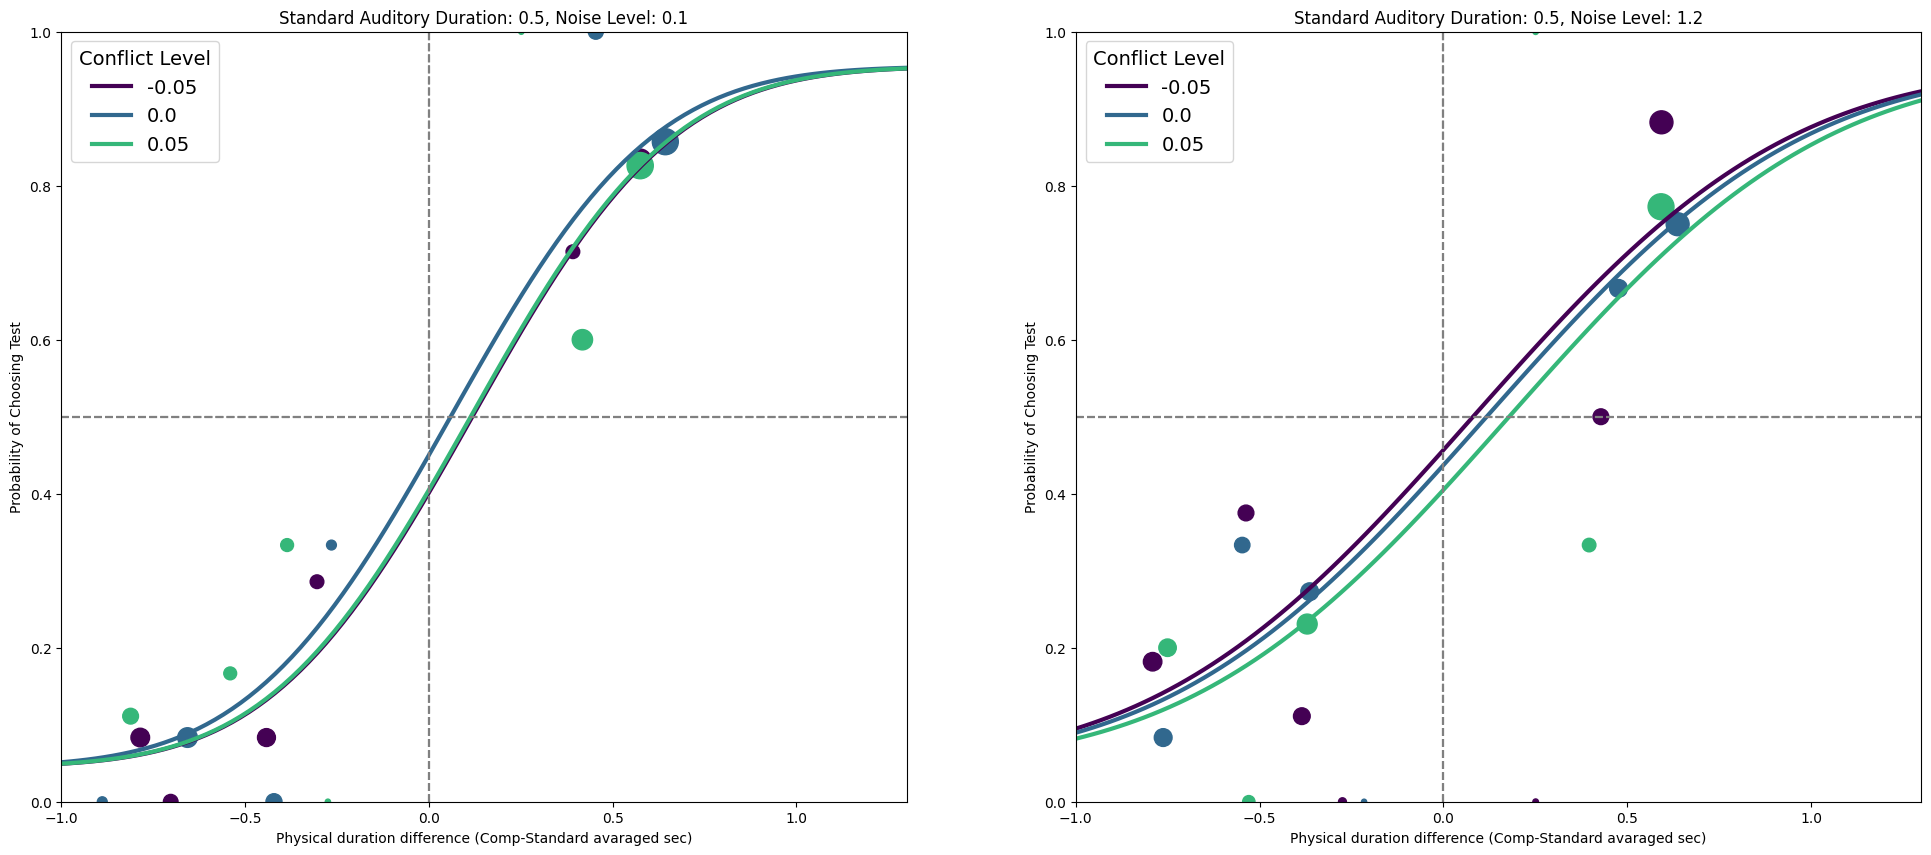

In [ ]:
plt.figure(figsize=(8*3,3*2))
#plt.Subplot(3,2)

m=0
for i, standardLevel in enumerate(standardDurLevels):
    lambda_ = lambda_fit
    print(f"fitted lambda {lambda_} ")
    for j, noiseLevel in enumerate(noiseLevels):
        sigma=best_fit.x[j+1]
        print(f"At noise level {noiseLevel } fitted sigma {sigma} ")
        for k, conflictLevel in enumerate(conflictLeves):
            m+=1        
            
            mu=best_fit.x[m+2]
            #filter data
            df=data[data['conflictDur']==conflictLevel]
            df= df[df["standardDur"]==standardLevel]
            df=df[df["riseDur"]==noiseLevel]
            dfFiltered=groupByChooseTest(df)
            # select levels
            levels=dfFiltered[intensityVariable].values
            responses=dfFiltered['num_of_chose_test'].values
            totalResponses=dfFiltered['total_responses'].values
            # print fitted parameters

            print(f"Noise: {noiseLevel}, Conflict: {conflictLevel}, fit sigma: {sigma} fit mu: {mu}")
            # plot psychometric function
            plt.subplot(1,2,j+1)
            maxX = max(levels) if len(levels) > 0 else 1.3  # Handle case with no levels
            if maxX < 1.3:
                maxX = 1.3
            plt.xlim(-1, maxX)
            plt.ylim(0, 1)
            x = np.linspace(-1, maxX, 100)

            y = psychometric_function(x, lambda_,mu,sigma)  # Use muA0_fit for the mean

            color=sns.color_palette("viridis", as_cmap=True)(k / len(conflictLeves))  # Use a colormap for different conflict levels
            plt.plot(x, y, label=round(conflictLevel, 2), color=color, linewidth=3)  # Plot the fitted psychometric function
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel('Physical duration difference (Comp-Standard avaraged sec)')
            plt.ylabel('Probability of Choosing Test')
            plt.title(f'Standard Auditory Duration: {round(standardLevel,2)}, Noise Level: {round(noiseLevel,2)}')
            # add fitted parameters to the plot
            # plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {fitted_params[1]:.2f}\nsigma: {fitted_params[2]:.2f}', fontsize=12, 
            #          bbox=dict(facecolor='white', alpha=0.5))
            plt.legend(title="Conflict Level", fontsize=14, title_fontsize=14)
            bin_and_plot(dfFiltered, bin_method='cut', bins=8, plot=True,color=color)
            
